In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math as m
import os
import hashlib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:.5f}'.format

filepath = os.path.join(os.getcwd(),"Data")
labeled_dataset = pd.read_csv(os.path.join(filepath,"train.csv"), index_col = None)
"Dataset Size (Rows, Columns): " + str(labeled_dataset.shape)

'Dataset Size (Rows, Columns): (188318, 132)'

After importing the data and our necesary packages, let's take a look at the training set provided to us.

In [2]:
labeled_dataset.head(n=7) #mix of categorical and continuous variables

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9    ...       cont6   cont7  \
0   1    A    B    A    B    A    A    A    A    B    ...     0.71837 0.33506   
1   2    A    B    A    A    A    A    A    A    B    ...     0.43892 0.43659   
2   5    A    B    A    A    B    A    A    A    B    ...     0.28965 0.31554   
3  10    B    B    A    B    A    A    A    A    B    ...     0.44094 0.39113   
4  11    A    B    A    B    A    A    A    A    B    ...     0.17819 0.24741   
5  13    A    B    A    A    A    A    A    A    B    ...     0.36446 0.40116   
6  14    A    A    A    A    B    A    A    A    A    ...     0.38151 0.36377   

    cont8   cont9  cont10  cont11  cont12  cont13  cont14       loss  
0 0.30260 0.67135 0.83510 0.56974 0.59465 0.82249 0.71484 2213.18000  
1 0.60087 0.35127 0.43919 0.33831 0.36631 0.61143 0.30450 1283.60000  
2 0.27320 0.26076 0.32446 0.38140 0.37342 0.19571 0.77443 3005.09000  
3 0.31796 0.32128 0.44467 0.32792 0.32157 0.60508 0.60264  939.85000  
4 0.24564 0.22089 0.21230 0.20469 0.20221 0.24601 0.43261 2763.85000  
5 0.26847 0.46226 0.50556 0.36679 0.35925 0.34525 0.72679 5142.87000  
6 0.24564 0.40455 0.47225 0.33483 0.35225 0.34224 0.38293 1132.22000  

[7 rows x 132 columns]

There is a mix of categorical variables and continuous variables. 

The variable names have been (presumbably) scrubbed of identifying information for privacy reasons, and thus domain knowledge of the insurance pricing process will not be of much help in this excercise. Category names have been converted into letters, and it appears that the continuous variables, except for the loss variable, have been normalized to fit between 0 and 1.

The "loss" variable, our target variable, is continuous. This will be a regression problem.

In [3]:
labeled_dataset.isnull().sum().sum() #no missing data!

0

Luckily, there doesn't seem to be any variables with missing values, so no imputation or adjustments for missing data need to be made. Looks like the ETL pipeline is already in place and functioning well, so there's no need to data munging/ data janitor work.

Let's take a look at the continuous variables.

In [4]:
cont_dataset = labeled_dataset.iloc[:,-15:].copy()
cont_dataset.head(n=7)

cont1   cont2   cont3   cont4   cont5   cont6   cont7   cont8   cont9  \
0 0.72630 0.24592 0.18758 0.78964 0.31006 0.71837 0.33506 0.30260 0.67135   
1 0.33051 0.73707 0.59268 0.61413 0.88583 0.43892 0.43659 0.60087 0.35127   
2 0.26184 0.35832 0.48420 0.23692 0.39707 0.28965 0.31554 0.27320 0.26076   
3 0.32159 0.55578 0.52799 0.37382 0.42227 0.44094 0.39113 0.31796 0.32128   
4 0.27320 0.15999 0.52799 0.47320 0.70427 0.17819 0.24741 0.24564 0.22089   
5 0.54667 0.68176 0.63422 0.37382 0.30268 0.36446 0.40116 0.26847 0.46226   
6 0.47145 0.73707 0.61366 0.18914 0.29540 0.38151 0.36377 0.24564 0.40455   

   cont10  cont11  cont12  cont13  cont14       loss  
0 0.83510 0.56974 0.59465 0.82249 0.71484 2213.18000  
1 0.43919 0.33831 0.36631 0.61143 0.30450 1283.60000  
2 0.32446 0.38140 0.37342 0.19571 0.77443 3005.09000  
3 0.44467 0.32792 0.32157 0.60508 0.60264  939.85000  
4 0.21230 0.20469 0.20221 0.24601 0.43261 2763.85000  
5 0.50556 0.36679 0.35925 0.34525 0.72679 5142.87000  
6 0.47225 0.33483 0.35225 0.34224 0.38293 1132.22000

In [5]:
cont_dataset.describe() #excluding loss, all the continuous variables are between 0 and 1-ish.

cont1        cont2        cont3        cont4        cont5  \
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000   
mean       0.49386      0.50719      0.49892      0.49181      0.48743   
std        0.18764      0.20720      0.20210      0.21129      0.20903   
min        0.00002      0.00115      0.00263      0.17692      0.28114   
25%        0.34609      0.35832      0.33696      0.32735      0.28114   
50%        0.47578      0.55578      0.52799      0.45289      0.42227   
75%        0.62391      0.68176      0.63422      0.65207      0.64331   
max        0.98498      0.86265      0.94425      0.95430      0.98367   

             cont6        cont7        cont8        cont9       cont10  \
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000   
mean       0.49094      0.48497      0.48644      0.48551      0.49807   
std        0.20527      0.17845      0.19937      0.18166      0.18588   
min        0.01268      0.06950      0.23688      0.00008      0.00000   
25%        0.33611      0.35018      0.31280      0.35897      0.36458   
50%        0.44094      0.43829      0.44106      0.44145      0.46119   
75%        0.65502      0.59104      0.62358      0.56682      0.61459   
max        0.99716      1.00000      0.98020      0.99540      0.99498   

            cont11       cont12       cont13       cont14         loss  
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000  
mean       0.49351      0.49315      0.49314      0.49572   3037.33769  
std        0.20974      0.20943      0.21278      0.22249   2904.08619  
min        0.03532      0.03623      0.00023      0.17972      0.67000  
25%        0.31096      0.31166      0.31576      0.29461   1204.46000  
50%        0.45720      0.46229      0.36355      0.40740   2115.57000  
75%        0.67892      0.67576      0.68997      0.72462   3864.04500  
max        0.99874      0.99848      0.98849      0.84485 121012.25000

Initial suspicions that the continuous variables (except for loss) were normalized between 0 and 1 are true. 

The loss variable seems to be skewed to the right. Let's plot the histogram of the loss variable to gain idea of the distribution shape.

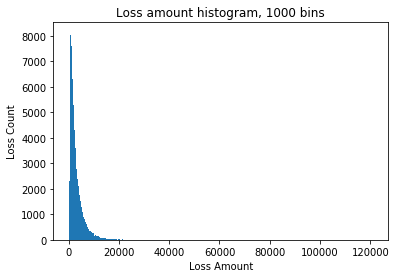

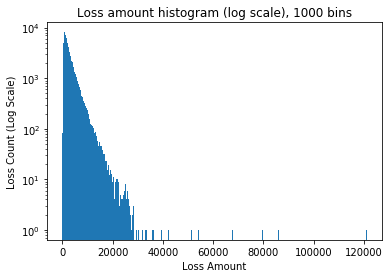

In [6]:
plt.hist(cont_dataset.loss, 1000);
plt.title("Loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset.loss, 1000);
plt.title("Loss amount histogram (log scale), 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count (Log Scale)");
plt.yscale("log");
plt.show(); #loss amounts are heavily skewed to the right

Loss is heavily skewed to the right. Plotting the histogram with a logarithmic scale shows that o

In [7]:
cont_dataset['logloss'] = np.log(cont_dataset['loss'])

cont_scaler = StandardScaler()
loss_scaler = StandardScaler()

cont_dataset_var = cont_dataset.iloc[:,:15].copy()
cont_dataset_var = pd.DataFrame(cont_scaler.fit_transform(cont_dataset_var),columns=cont_dataset_var.columns)
cont_dataset_logloss = cont_dataset.iloc[:,-1:].copy()
cont_dataset_logloss = pd.DataFrame(loss_scaler.fit_transform(cont_dataset_logloss),columns=cont_dataset_logloss.columns)

cont_dataset_scaled = pd.concat([cont_dataset_var, cont_dataset_logloss], axis = 1)
cont_dataset_scaled.describe()

cont1        cont2        cont3        cont4        cont5  \
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000   
mean      -0.00000      0.00000     -0.00000     -0.00000     -0.00000   
std        1.00000      1.00000      1.00000      1.00000      1.00000   
min       -2.63188     -2.44226     -2.45559     -1.49032     -0.98688   
25%       -0.78753     -0.71848     -0.80135     -0.77835     -0.98688   
50%       -0.09634      0.23452      0.14385     -0.18423     -0.31173   
75%        0.69309      0.84253      0.66948      0.75848      0.74578   
max        2.61732      1.71556      2.20348      2.18885      2.37409   

             cont6        cont7        cont8        cont9       cont10  \
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000   
mean       0.00000     -0.00000     -0.00000     -0.00000     -0.00000   
std        1.00000      1.00000      1.00000      1.00000      1.00000   
min       -2.32989     -2.32820     -1.25173     -2.67217     -2.67956   
25%       -0.75431     -0.75537     -0.87093     -0.69656     -0.71814   
50%       -0.24358     -0.26162     -0.22760     -0.24252     -0.19839   
75%        0.79931      0.59442      0.68788      0.44762      0.62689   
max        2.46608      2.88613      2.47662      2.80686      2.67336   

            cont11       cont12       cont13       cont14         loss  \
count 188318.00000 188318.00000 188318.00000 188318.00000 188318.00000   
mean      -0.00000     -0.00000     -0.00000     -0.00000      0.00000   
std        1.00000      1.00000      1.00000      1.00000      1.00000   
min       -2.18460     -2.18176     -2.31656     -1.42029     -1.04566   
25%       -0.87038     -0.86660     -0.83364     -0.90390     -0.63114   
50%       -0.17311     -0.14738     -0.60905     -0.39694     -0.31740   
75%        0.88403      0.87195      0.92508      1.02885      0.28467   
max        2.40889      2.41294      2.32806      1.56922     40.62387   

           logloss  
count 188318.00000  
mean       0.00000  
std        1.00000  
min       -9.95946  
25%       -0.72855  
50%       -0.03472  
75%        0.70726  
max        4.94956

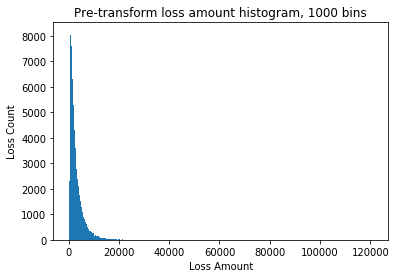

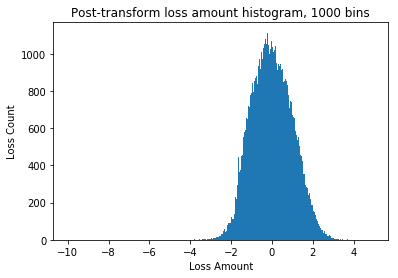

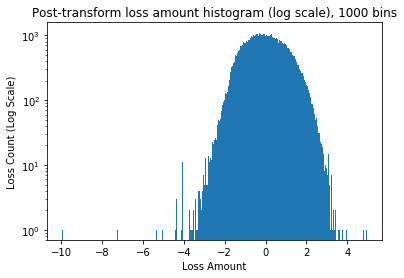

In [8]:
plt.hist(cont_dataset.loss, 1000);
plt.title("Pre-transform loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset_scaled.logloss, 1000);
plt.title("Post-transform loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset_scaled.logloss, 1000);
plt.title("Post-transform loss amount histogram (log scale), 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count (Log Scale)");
plt.yscale("log");
plt.show(); #loss amounts roughly resemble a 0-centered normal distribution after transformation

In [9]:
cat_dataset = labeled_dataset.iloc[:,1:-15].copy()
cat_dataset.head(n=7) #categorical variables

cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ...   cat107 cat108  \
0    A    B    A    B    A    A    A    A    B     A  ...        J      G   
1    A    B    A    A    A    A    A    A    B     B  ...        K      K   
2    A    B    A    A    B    A    A    A    B     B  ...        F      A   
3    B    B    A    B    A    A    A    A    B     A  ...        K      K   
4    A    B    A    B    A    A    A    A    B     B  ...        G      B   
5    A    B    A    A    A    A    A    A    B     A  ...        F      B   
6    A    A    A    A    B    A    A    A    A     A  ...        F      B   

  cat109 cat110 cat111 cat112 cat113 cat114 cat115 cat116  
0     BU     BC      C     AS      S      A      O     LB  
1     BI     CQ      A     AV     BM      A      O     DP  
2     AB     DK      A      C     AF      A      I     GK  
3     BI     CS      C      N     AE      A      O     DJ  
4      H      C      C      Y     BM      A      K     CK  
5     BI     CS      A     AS     AE      A      K     DJ  
6     BI     DK      A      J     AF      A      K     DJ  

[7 rows x 116 columns]

In [10]:
pd.DataFrame(cat_dataset.nunique(),columns=['Unique Categories']).head(n=7)
pd.DataFrame(cat_dataset.nunique(),columns=['Unique Categories']).tail(n=7)
"There are " + str(list(cat_dataset.nunique()).count(2)) + " binary variables."

Unique Categories
cat1                  2
cat2                  2
cat3                  2
cat4                  2
cat5                  2
cat6                  2
cat7                  2

Unique Categories
cat110                131
cat111                 16
cat112                 51
cat113                 61
cat114                 19
cat115                 23
cat116                326

'There are 72 binary variables.'

In [11]:
min_freq=[] #least common category occurences
min2_freq=[] #second least common category occurences
avg_freq=[] #average category occurence number
freq_std=[] #standard deviation in category occurence number
for column in cat_dataset.columns:
    min_freq.append(int(cat_dataset[column].value_counts().min()))
    min2_freq.append(int(cat_dataset[column].value_counts().nsmallest().iloc[1]))
    avg_freq.append(int(cat_dataset[column].value_counts().mean()))
    freq_std.append(int(cat_dataset[column].value_counts().std()))
extra_desc = pd.DataFrame([min_freq,min2_freq,avg_freq,freq_std],columns=cat_dataset.columns)
extra_desc = extra_desc.rename({0:"minfreq",1:"min2freq",2:"avgfreq",3:"freqstd"})
cat_dataset.describe().append(extra_desc)

cat1    cat2    cat3    cat4    cat5    cat6    cat7    cat8  \
count     188318  188318  188318  188318  188318  188318  188318  188318   
unique         2       2       2       2       2       2       2       2   
top            A       A       A       A       A       A       A       A   
freq      141550  106721  177993  128395  123737  131693  183744  177274   
minfreq    46768   81597   10325   59923   64581   56625    4574   11044   
min2freq  141550  106721  177993  128395  123737  131693  183744  177274   
avgfreq    94159   94159   94159   94159   94159   94159   94159   94159   
freqstd    67020   17765  118559   48417   41829   53081  126692  117542   

            cat9   cat10   ...    cat107  cat108  cat109  cat110  cat111  \
count     188318  188318   ...    188318  188318  188318  188318  188318   
unique         2       2   ...        20      11      84     131      16   
top            A       A   ...         F       B      BI      CL       A   
freq      113122  160213   ...     47310   65512  152918   25305  128395   
minfreq    75196   28105   ...         2     213       1       1       2   
min2freq  113122  160213   ...         2     520       1       1       3   
avgfreq    94159   94159   ...      9415   17119    2241    1437   11769   
freqstd    26817   93414   ...     13310   20051   16814    4649   32247   

          cat112  cat113  cat114  cat115  cat116  
count     188318  188318  188318  188318  188318  
unique        51      61      19      23     326  
top            E      BM       A       K      HK  
freq       25148   26191  131693   43866   21061  
minfreq       30       1       1       1       1  
min2freq     144       1       1       2       1  
avgfreq     3692    3087    9911    8187     577  
freqstd     5361    4986   29975   12032    2008  

[8 rows x 116 columns]

In [12]:
# discard high cardinality variables
threshold = 0.0025
for column in cat_dataset.columns:
    if cat_dataset[column].value_counts().min() < threshold*cat_dataset.shape[0]:
        cat_dataset = cat_dataset.drop([column], axis=1)
        
min_freq=[]
min2_freq=[]
avg_freq=[]
freq_std=[]
for column in cat_dataset.columns:
    min_freq.append(int(cat_dataset[column].value_counts().min()))
    min2_freq.append(int(cat_dataset[column].value_counts().nsmallest().iloc[1]))
    avg_freq.append(int(cat_dataset[column].value_counts().mean()))
    freq_std.append(int(cat_dataset[column].value_counts().std()))
    
extra_desc = pd.DataFrame([min_freq,min2_freq,avg_freq,freq_std],columns=cat_dataset.columns)
extra_desc = extra_desc.rename({0:"minfreq",1:"min2freq",2:"avgfreq",3:"freqstd"})
cat_dataset.describe().append(extra_desc)

cat1    cat2    cat3    cat4    cat5    cat6    cat7    cat8  \
count     188318  188318  188318  188318  188318  188318  188318  188318   
unique         2       2       2       2       2       2       2       2   
top            A       A       A       A       A       A       A       A   
freq      141550  106721  177993  128395  123737  131693  183744  177274   
minfreq    46768   81597   10325   59923   64581   56625    4574   11044   
min2freq  141550  106721  177993  128395  123737  131693  183744  177274   
avgfreq    94159   94159   94159   94159   94159   94159   94159   94159   
freqstd    67020   17765  118559   48417   41829   53081  126692  117542   

            cat9   cat10   ...     cat76   cat79   cat80   cat81   cat82  \
count     188318  188318   ...    188318  188318  188318  188318  188318   
unique         2       2   ...         3       4       4       4       4   
top            A       A   ...         A       B       D       D       B   
freq      113122  160213   ...    181347  152929  137505  154385  147536   
minfreq    75196   28105   ...       788    1668     783     788    2655   
min2freq  113122  160213   ...      6183    7064    3492    9013   18805   
avgfreq    94159   94159   ...     62772   47079   47079   47079   47079   
freqstd    26817   93414   ...    102723   71378   63823   72187   67416   

           cat83   cat85   cat86   cat87   cat98  
count     188318  188318  188318  188318  188318  
unique         4       4       4       4       5  
top            B       B       B       B       A  
freq      141534  186005  103852  166992  105492  
minfreq     4958     514    1589     788     542  
min2freq   15788     788   10290    8819   10242  
avgfreq    47079   47079   47079   47079   37663  
freqstd    63555   92617   49317   80075   42304  

[8 rows x 65 columns]

In [13]:
# cat_dataset = cat_dataset.apply(LabelEncoder().fit_transform)
# cat_onehot = OneHotEncoder()
# cat_dataset = cat_onehot.fit_transform(cat_dataset)
# cat_dataset

cat_dataset = pd.get_dummies(data=cat_dataset,drop_first=True) #convert categorial variables to one-hot encoding
cat_dataset.head(n=7)

cat1_B  cat2_B  cat3_B  cat4_B  cat5_B  cat6_B  cat7_B  cat8_B  cat9_B  \
0       0       1       0       1       0       0       0       0       1   
1       0       1       0       0       0       0       0       0       1   
2       0       1       0       0       1       0       0       0       1   
3       1       1       0       1       0       0       0       0       1   
4       0       1       0       1       0       0       0       0       1   
5       0       1       0       0       0       0       0       0       1   
6       0       0       0       0       1       0       0       0       0   

   cat10_B   ...     cat86_B  cat86_C  cat86_D  cat87_B  cat87_C  cat87_D  \
0        0   ...           0        0        1        1        0        0   
1        1   ...           0        0        1        1        0        0   
2        1   ...           1        0        0        1        0        0   
3        0   ...           0        0        1        1        0        0   
4        1   ...           1        0        0        0        1        0   
5        0   ...           1        0        0        1        0        0   
6        0   ...           1        0        0        1        0        0   

   cat98_B  cat98_C  cat98_D  cat98_E  
0        0        1        0        0  
1        0        0        1        0  
2        0        0        0        0  
3        0        0        1        0  
4        0        0        0        0  
5        0        0        0        0  
6        0        0        0        0  

[7 rows x 85 columns]

In [14]:
cleaned_dataset = pd.concat([labeled_dataset.id,cat_dataset,cont_dataset_scaled], axis=1)
cleaned_dataset.head(n=7)

id  cat1_B  cat2_B  cat3_B  cat4_B  cat5_B  cat6_B  cat7_B  cat8_B  cat9_B  \
0   1       0       1       0       1       0       0       0       0       1   
1   2       0       1       0       0       0       0       0       0       1   
2   5       0       1       0       0       1       0       0       0       1   
3  10       1       1       0       1       0       0       0       0       1   
4  11       0       1       0       1       0       0       0       0       1   
5  13       0       1       0       0       0       0       0       0       1   
6  14       0       0       0       0       1       0       0       0       0   

    ...       cont7    cont8    cont9   cont10   cont11   cont12   cont13  \
0   ...    -0.84007 -0.92209  1.02303  1.81322  0.36348  0.48464  1.54789   
1   ...    -0.27114  0.57397 -0.73894 -0.31675 -0.73997 -0.60567  0.55595   
2   ...    -0.94943 -1.06956 -1.23718 -0.93399 -0.53454 -0.57169 -1.39784   
3   ...    -0.52587 -0.84505 -0.90403 -0.28727 -0.78955 -0.81929  0.52609   
4   ...    -1.33126 -1.20779 -1.45666 -1.53740 -1.37708 -1.38921 -1.16144   
5   ...    -0.46965 -1.09328 -0.12797  0.04032 -0.60420 -0.63937 -0.69505   
6   ...    -0.67920 -1.20779 -0.44565 -0.13889 -0.75658 -0.67279 -0.70919   

    cont14     loss  logloss  
0  0.98489 -0.28379  0.02084  
1 -0.85947 -0.60389 -0.65016  
2  1.25269 -0.01110  0.39760  
3  0.48059 -0.72226 -1.03410  
4 -0.28366 -0.09417  0.29452  
5  1.03860  0.72503  1.05941  
6 -0.50693 -0.65601 -0.80473  

[7 rows x 102 columns]

In [15]:
def test_split(id, seed, test_proportion):
    if type(test_proportion) not in [float, int] or test_proportion > 1 or test_proportion < 0:
        raise ValueError("Test proportion must be a real number between 0 and 1")
    test = str(id) + str(seed)
    test_digest = hashlib.md5(test.encode("ascii")).hexdigest()
    test_hex = int(test_digest[-6:], 16) #last 6 digits only
    split = test_hex/0xFFFFFF
    if split > test_proportion:
        return 0
    else:
        return 1

cleaned_dataset['split'] = cleaned_dataset['id'].map(lambda x: test_split(id = x, seed = 'testing set', test_proportion = 0.20))
cleaned_dataset['split'].sum()/cleaned_dataset.shape[0] #verify split percentage is correct

test = cleaned_dataset.loc[(cleaned_dataset.split == 1)]
train_valid = cleaned_dataset.loc[(cleaned_dataset.split == 0)].copy()
train_valid['split'] = train_valid['id'].map(lambda x: test_split(id = x, seed = 'validation set', test_proportion = 0.25))
train_valid['split'].sum()/train_valid.shape[0] #verify split percentage is correct
train = train_valid.loc[(train_valid.split == 0)]
valid = train_valid.loc[(train_valid.split == 1)]


train_x = train.iloc[:,1:-3].copy()
train_y = train.iloc[:,-2:-1].copy()
valid_x = valid.iloc[:,1:-3].copy()
valid_y = valid.iloc[:,-2:-1].copy()
test_x = test.iloc[:,1:-3].copy()
test_y = test.iloc[:,-2:-1].copy()

0.1991631177051583

0.24872026098718936

In [22]:
valid_min = 0.47
# # 0.46722597 was the lowest loss recorded 
# #0.08998513

In [36]:
tf.reset_default_graph()
tf_x = tf.placeholder(tf.float32, [None, train_x.shape[1]])
tf_y = tf.placeholder(tf.float32, [None, train_y.shape[1]])


reg_param = 0.0001
    
layer1 = tf.layers.dense(tf_x, 75, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer2 = tf.layers.dense(layer1, 60, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer3 = tf.layers.dense(layer2, 50, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer4 = tf.layers.dense(layer3, 25, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
output = tf.layers.dense(layer4, 1, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))

# layer1 = tf.layers.dense(tf_x, 100, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
# layer2 = tf.layers.dense(layer1, 100, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
# layer3 = tf.layers.dense(layer2, 100, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
# layer4 = tf.layers.dense(layer3, 40, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
# output = tf.layers.dense(layer3, 1, kernel_regularizer=tf.contrib.layers.l2_regularizer(reg_param))


loss = tf.losses.mean_squared_error(tf_y, output) + tf.losses.get_regularization_loss()
actual_loss = tf.losses.mean_squared_error(tf_y, output)
optimizer = tf.train.AdamOptimizer(0.0001)
train_op = optimizer.minimize(loss)
loss_history_train = []
loss_history_valid = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
# saver.restore(sess, './params')
for epoch in range(2009):       
    valid_loss = sess.run(actual_loss, {tf_x: valid_x, tf_y: valid_y})
    loss_history_valid.append(valid_loss)
#     train_loss = sess.run(loss, {tf_x: train_x, tf_y: train_y})
#     loss_history_train.append(train_loss)    
    if valid_loss < valid_min:
        saver.save(sess, './params', write_meta_graph=False)
        valid_min = valid_loss
        print(valid_min)
        break
#     random_rows = np.random.choice(train.shape[0], 25, replace=False)    
#     sess.run(train_op, {tf_x: train_x.iloc[random_rows, :], tf_y: train_y.iloc[random_rows, :]})    
    sess.run(train_op, {tf_x: train_x, tf_y: train_y})

# saver.save(sess, './params', write_meta_graph=False)

valid_loss = sess.run(actual_loss, {tf_x: valid_x, tf_y: valid_y})
train_loss = sess.run(actual_loss, {tf_x: train_x, tf_y: train_y})

train_pred_nn = sess.run(output, {tf_x: train_x})
valid_pred_nn = sess.run(output, {tf_x: valid_x})
sess.close()

train_pred_nn = pd.DataFrame(train_pred_nn, columns = ['prednn'])
valid_pred_nn = pd.DataFrame(valid_pred_nn, columns = ['prednn'])

'./params'

Mean squared error on the training set is 0.450240
Mean squared error on the validation set is 0.476091


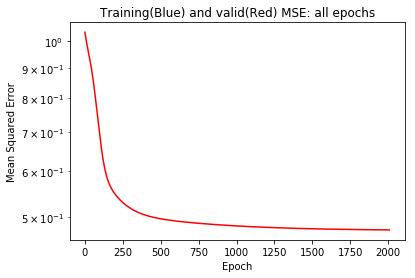

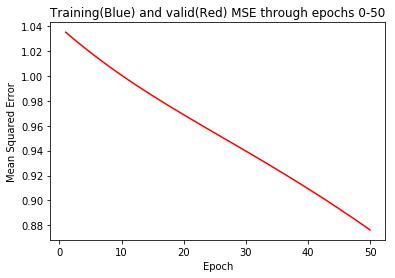

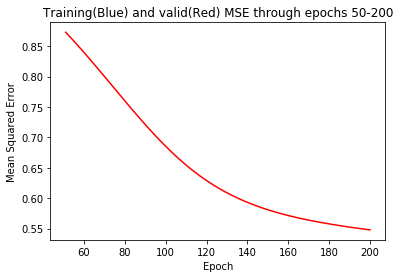

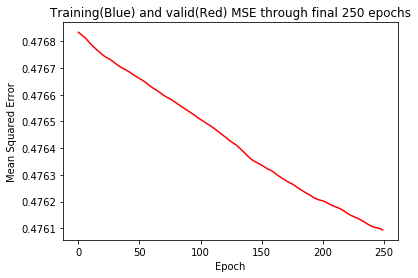

In [37]:
print("Mean squared error on the training set is %f" % train_loss)
print("Mean squared error on the validation set is %f" % valid_loss)

# plt.plot(loss_history_train, 'b');
plt.plot(loss_history_valid, 'r');
plt.title("Training(Blue) and valid(Red) MSE: all epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.yscale('log');
plt.show();

# plt.plot(np.arange(1,51), loss_history_train[:50], 'b');
plt.plot(np.arange(1,51), loss_history_valid[:50], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 0-50");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();


# plt.plot(np.arange(51,201), loss_history_train[50:200], 'b');
plt.plot(np.arange(51,201), loss_history_valid[50:200], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 50-200");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();


# # plt.plot(np.arange(1001,2001),loss_history_train[1000:2000], 'b');
# plt.plot(np.arange(1001,2001),loss_history_valid[1000:2000], 'r');
# plt.title("Training(Blue) and valid(Red) MSE through epochs 1000-2000");
# plt.xlabel("Epoch");
# plt.ylabel("Mean Squared Error");
# plt.show();

# # plt.plot(np.arange(2001,4751),loss_history_train[2000:4750], 'b');
# plt.plot(np.arange(2001,4751),loss_history_valid[2000:4750], 'r');
# plt.title("Training(Blue) and valid(Red) MSE through epochs 2000-4750");
# plt.xlabel("Epoch");
# plt.ylabel("Mean Squared Error");
# plt.show();

# plt.plot(loss_history_train[-250:], 'b');
plt.plot(loss_history_valid[-250:], 'r');
plt.title("Training(Blue) and valid(Red) MSE through final 250 epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();

In [38]:
min(loss_history_valid)

0.47609362

In [39]:
valid_pred_nn = np.exp(loss_scaler.inverse_transform(valid_pred_nn))
valid_y_actual = np.exp(loss_scaler.inverse_transform(valid_y))
mse_nn = mean_squared_error(valid_y_actual, valid_pred_nn) ** 0.5
mae_nn = mean_absolute_error(valid_y_actual, valid_pred_nn)
print("Root mean squared error of neural network predictions of actual dollar amounts is $%f" % mse_nn) 
print("Mean absolute error of neural network predictions of actual dollar amounts is $%f" % mae_nn) 
#1925.3218 was the lowest loss recorded

Root mean squared error of neural network predictions of actual dollar amounts is $1943.255442
Mean absolute error of neural network predictions of actual dollar amounts is $1174.826209


In [389]:
np.random.seed(42)
random_rows = np.random.choice(train.shape[0], 100, replace=False)
knnr_loss_history = []
for i in range(1,26):
    knnr = KNeighborsRegressor(n_neighbors=i, weights="distance")
    knnr = knnr.fit(train_x.iloc[random_rows, :], train_y.iloc[random_rows, :])
    train_pred_knnr = pd.DataFrame(knnr.predict(train_x), columns = ['predknnr'])
    valid_pred_knnr = pd.DataFrame(knnr.predict(valid_x), columns = ['predknnr'])
    valid_pred_knnr = np.exp(loss_scaler.inverse_transform(valid_pred_knnr))    
    mse_knnr = mean_squared_error(valid_y_actual, valid_pred_knnr) ** 0.5
    knnr_loss_history.append(mse_knnr)

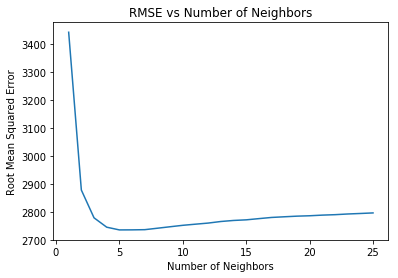

The minimum RMSE of a signle kNN's predictions of actual dollar amounts is $2736.732456


In [20]:
plt.plot(np.arange(1,26), knnr_loss_history);
plt.xlabel("Number of Neighbors");
plt.ylabel("Root Mean Squared Error");
plt.title("RMSE vs Number of Neighbors");
plt.show(); #use 5 neighbors for minimum RMSE  
print("The minimum RMSE of a signle kNN's predictions of actual dollar amounts is $%f" % min(knnr_loss_history)); 

In [21]:
knnr = BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=5, weights="distance"),
                        n_estimators=20,
                        max_samples=100,
                        max_features=5,
                        bootstrap=False,
                        random_state=42)
knnr = knnr.fit(train_x, train_y.values.ravel())
valid_pred_knnr = pd.DataFrame(knnr.predict(valid_x), columns = ['predknnr'])
valid_pred_knnr = np.exp(loss_scaler.inverse_transform(valid_pred_knnr))    
mse_knnr = mean_squared_error(valid_y_actual, valid_pred_knnr) ** 0.5
mae_knnr = mean_absolute_error(valid_y_actual, valid_pred_knnr)
print("The minimum RMSE of 20 kNN predictions(ensemble) of actual dollar amounts is $%f" % mse_knnr)
print("Mean absolute error of 20 kNN predictions(ensemble) of actual dollar amounts is $%f" % mae_knnr)

The minimum RMSE of 20 kNN predictions(ensemble) of actual dollar amounts is $2679.506244
Mean absolute error of 20 kNN predictions(ensemble) of actual dollar amounts is $1605.969715


In [22]:
random_forest = RandomForestRegressor(n_estimators=50,
                                      max_depth=20,
                                      max_features=30,
                                      min_samples_split = 25,
                                      bootstrap=False,
                                      random_state=42)
random_forest = random_forest.fit(train_x, train_y.values.ravel())
valid_pred_rf = pd.DataFrame(random_forest.predict(valid_x), columns = ['predrf'])
valid_pred_rf = np.exp(loss_scaler.inverse_transform(valid_pred_rf))    
mse_rf = mean_squared_error(valid_y_actual, valid_pred_rf) ** 0.5
mae_rf = mean_absolute_error(valid_y_actual, valid_pred_rf)
print("The RMSE of random forest predictions of actual dollar amounts is $%f" % mse_rf)
print("Mean absolute error of random forest predictions of actual dollar amounts is $%f" % mae_rf)

The RMSE of random forest predictions of actual dollar amounts is $2016.605967
Mean absolute error of random forest predictions of actual dollar amounts is $1203.483264


In [23]:
linsvr = LinearSVR()
linsvr = linsvr.fit(train_x, train_y.values.ravel())
valid_pred_linsvr = pd.DataFrame(linsvr.predict(valid_x), columns = ['predlinsvr'])
valid_pred_linsvr = np.exp(loss_scaler.inverse_transform(valid_pred_linsvr))
mse_linsvr = mean_squared_error(valid_y_actual, valid_pred_linsvr) ** 0.5
mae_linsvr = mean_absolute_error(valid_y_actual, valid_pred_linsvr)
print("The RMSE of linear SVR predictions of actual dollar amounts is $%f" % mse_linsvr)
print("Mean absolute error of linear SVR predictions of actual dollar amounts is $%f" % mae_linsvr)

The RMSE of linear SVR predictions of actual dollar amounts is $2173.881400
Mean absolute error of linear SVR predictions of actual dollar amounts is $1278.666285


In [24]:
kernelsvr = BaggingRegressor(base_estimator=SVR(),
                             n_estimators=2,
                             max_samples=2500,
                             bootstrap=False,
                             random_state=42)
kernelsvr = kernelsvr.fit(train_x, train_y.values.ravel())
valid_pred_kernelsvr = pd.DataFrame(kernelsvr.predict(valid_x), columns = ['predkernelsvr'])
valid_pred_kernelsvr = np.exp(loss_scaler.inverse_transform(valid_pred_kernelsvr))
mse_kernelsvr = mean_squared_error(valid_y_actual, valid_pred_kernelsvr) ** 0.5
mae_kernelsvr = mean_absolute_error(valid_y_actual, valid_pred_kernelsvr)
print("The RMSE of Kernel SVR predictions of actual dollar amounts is $%f" % mse_kernelsvr)
print("Mean absolute error of Kernel SVR predictions of actual dollar amounts is $%f" % mae_kernelsvr)

The RMSE of Kernel SVR predictions of actual dollar amounts is $2051.062195
Mean absolute error of Kernel SVR predictions of actual dollar amounts is $1240.834414


In [70]:
gb_forest = GradientBoostingRegressor(max_depth=7,
                                      n_estimators=250,
                                      random_state=42)
gb_forest = gb_forest.fit(train_x, train_y.values.ravel())
valid_pred_gb = pd.DataFrame(gb_forest.predict(valid_x), columns = ['predgb'])
valid_pred_gb = np.exp(loss_scaler.inverse_transform(valid_pred_gb))    
mse_gb = mean_squared_error(valid_y_actual, valid_pred_gb) ** 0.5
mae_gb = mean_absolute_error(valid_y_actual, valid_pred_gb)
print("The RMSE of gradient boosted forest predictions of actual dollar amounts is $%f" % mse_gb)
print("Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $%f" % mae_gb)

The RMSE of gradient boosted forest predictions of actual dollar amounts is $1932.767157
Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $1165.534416


In [26]:
ada_forest = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                    max_features=50,
                                                                    min_samples_split = 25),
                               random_state=42,
                               loss="square",
                               n_estimators=50)
ada_forest = ada_forest.fit(train_x, train_y.values.ravel())
valid_pred_ada = pd.DataFrame(ada_forest.predict(valid_x), columns = ['predada'])
valid_pred_ada = np.exp(loss_scaler.inverse_transform(valid_pred_ada))
mse_ada = mean_squared_error(valid_y_actual, valid_pred_ada) ** 0.5
mae_ada = mean_absolute_error(valid_y_actual, valid_pred_ada)
print("The RMSE of adaboosted forest predictions of actual dollar amounts is $%f" % mse_ada)
print("Mean absolute error of adaboosted boosted forest predictions of actual dollar amounts is $%f" % mae_ada)

The RMSE of adaboosted forest predictions of actual dollar amounts is $2016.201292
Mean absolute error of adaboosted boosted forest predictions of actual dollar amounts is $1212.356293


In [27]:
lm = LinearRegression().fit(train_x, train_y.values.ravel())
valid_pred_lm = pd.DataFrame(lm.predict(valid_x), columns = ['predlm'])
valid_pred_lm = np.exp(loss_scaler.inverse_transform(valid_pred_lm))
mse_lm = mean_squared_error(valid_y_actual, valid_pred_lm) ** 0.5
mae_lm = mean_absolute_error(valid_y_actual, valid_pred_lm)
print("The RMSE of linear regression predictions of actual dollar amounts is $%f" % mse_lm)
print("Mean absolute error of linear regression predictions of actual dollar amounts is $%f" % mae_lm)

The RMSE of linear regression predictions of actual dollar amounts is $2147.487458
Mean absolute error of linear regression predictions of actual dollar amounts is $1271.485751


In [75]:
train_pred = train_pred_nn.copy()
train_pred["predknnr"] = knnr.predict(train_x)
train_pred["predrf"] = random_forest.predict(train_x)
train_pred["predlinsvr"] = linsvr.predict(train_x)
train_pred["predkernelsvr"] = kernelsvr.predict(train_x)
train_pred["predgb"] = gb_forest.predict(train_x) 
train_pred["predada"] = ada_forest.predict(train_x)
train_pred["predlm"] = lm.predict(train_x)
train_x1 = train_x.reset_index(drop=True)
train_pred = pd.concat([train_x1, train_pred], axis = 1)
train_pred.head()

cat1_B  cat2_B  cat3_B  cat4_B  cat5_B  cat6_B  cat7_B  cat8_B  cat9_B  \
0       0       1       0       0       1       0       0       0       1   
1       1       1       0       1       0       0       0       0       1   
2       0       1       0       0       0       0       0       0       1   
3       0       0       0       0       1       0       0       0       0   
4       0       1       0       0       1       1       0       0       1   

   cat10_B   ...      cont13   cont14   prednn  predknnr   predrf  predlinsvr  \
0        1   ...    -1.39784  1.25269  0.86086   0.39623  0.57545     0.88589   
1        0   ...     0.52609  0.48059 -0.74875  -0.13721 -0.69249    -0.71865   
2        0   ...    -0.69505  1.03860  1.01468   0.44686  0.92974     0.53395   
3        0   ...    -0.70919 -0.50693 -0.69166  -0.09743 -0.70450    -0.61726   
4        0   ...     1.54789 -0.90430  1.20512   0.43323  1.15517     1.11821   

   predkernelsvr   predgb  predada   predlm  
0        0.87775  0.75952  0.59117  0.85659  
1       -0.76149 -0.71702 -0.75975 -0.72648  
2        0.68409  0.77150  1.19562  0.52357  
3       -0.47046 -0.76806 -0.83494 -0.60229  
4        0.82731  1.31773  1.02011  1.08415  

[5 rows x 107 columns]

In [78]:
valid_pred = valid_pred_nn.copy()
valid_pred["predknnr"] = knnr.predict(valid_x)
valid_pred["predrf"] = random_forest.predict(valid_x)
valid_pred["predlinsvr"] = linsvr.predict(valid_x)
valid_pred["predkernelsvr"] = kernelsvr.predict(valid_x)
valid_pred["predgb"] = gb_forest.predict(valid_x) 
valid_pred["predada"] = ada_forest.predict(valid_x)
valid_pred["predlm"] = lm.predict(valid_x)
valid_x1 = valid_x.reset_index(drop=True)
valid_pred = pd.concat([valid_x1, valid_pred], axis = 1)
valid_pred.head()

cat1_B  cat2_B  cat3_B  cat4_B  cat5_B  cat6_B  cat7_B  cat8_B  cat9_B  \
0       0       1       0       1       0       0       0       0       1   
1       0       1       0       0       0       0       0       0       1   
2       0       1       0       1       0       0       0       0       1   
3       0       1       0       1       0       0       0       0       1   
4       0       0       0       0       1       0       0       0       0   

   cat10_B   ...      cont13   cont14   prednn  predknnr   predrf  predlinsvr  \
0        0   ...     1.54789  0.98489 -0.16466  -0.10819 -0.28255    -0.40908   
1        1   ...     0.55595 -0.85947 -0.39641   0.25033 -0.38262    -0.25530   
2        1   ...    -1.16144 -0.28366  0.42185   0.49711  0.44037     1.02348   
3        0   ...     1.72306 -1.13850  1.48744   0.49674  1.00193     1.05396   
4        0   ...     1.54789 -1.09867 -1.73617  -0.20217 -0.77686    -0.81082   

   predkernelsvr   predgb  predada   predlm  
0       -0.59944 -0.09281 -0.38478 -0.39403  
1       -0.13582 -0.42636 -0.28630 -0.25625  
2        0.94090  0.40274  0.39110  0.98810  
3        0.99586  1.40733  1.12185  1.01399  
4       -0.50727 -1.13512 -0.73249 -0.81861  

[5 rows x 107 columns]

In [58]:
tf.reset_default_graph()
tf_pred = tf.placeholder(tf.float32, [None, train_pred.shape[1]])
tf_y = tf.placeholder(tf.float32, [None, train_y.shape[1]])

    
layer1 = tf.layers.dense(tf_pred, 16, tf.nn.softsign)
layer2 = tf.layers.dense(layer1, 10, tf.nn.leaky_relu)
layer3 = tf.layers.dense(layer2, 6, tf.nn.leaky_relu)
layer4 = tf.layers.dense(layer3, 3, tf.nn.leaky_relu)
output = tf.layers.dense(layer4, 1)


loss = tf.losses.mean_squared_error(tf_y, output)
optimizer = tf.train.AdamOptimizer(0.03)
train_op = optimizer.minimize(loss)
loss_history_ptrain = []
loss_history_pvalid = []
valid_min = 0.46723

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
# saver.restore(sess, './stacked')
for epoch in range(10000):       
    valid_loss = sess.run(loss, {tf_pred: valid_pred, tf_y: valid_y})
    loss_history_pvalid.append(valid_loss)
#     train_loss = sess.run(loss, {tf_pred: train_pred, tf_y: train_y})
#     loss_history_ptrain.append(train_loss)    
    if valid_loss < valid_min:
        saver.save(sess, './stacked', write_meta_graph=False)
        valid_min = valid_loss
        print(valid_min)        
    random_rows = np.random.choice(train.shape[0], 250, replace=False)    
    sess.run(train_op, {tf_pred: train_pred.iloc[random_rows, :], tf_y: train_y.iloc[random_rows, :]})    
#     sess.run(train_op, {tf_pred: train_pred, tf_y: train_y})

# valid_loss = sess.run(loss, {tf_pred: valid_pred, tf_y: valid_y})
# train_loss = sess.run(loss, {tf_pred: train_pred, tf_y: train_y})

train_pred_stacked = sess.run(output, {tf_pred: train_pred})
valid_pred_stacked = sess.run(output, {tf_pred: valid_pred})
sess.close()

train_pred_stacked = pd.DataFrame(train_pred_stacked, columns = ['preds'])
valid_pred_stacked = pd.DataFrame(valid_pred_stacked, columns = ['preds'])

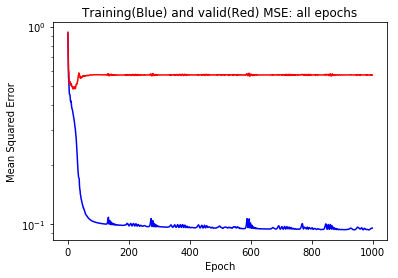

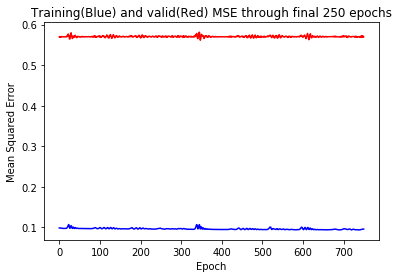

In [56]:
plt.plot(loss_history_ptrain, 'b');
plt.plot(loss_history_pvalid, 'r');
plt.title("Training(Blue) and valid(Red) MSE: all epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.yscale('log');
plt.show();

plt.plot(loss_history_ptrain[-750:], 'b');
plt.plot(loss_history_pvalid[-750:], 'r');
plt.title("Training(Blue) and valid(Red) MSE through final 250 epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();

In [57]:
valid_pred_stacked = np.exp(loss_scaler.inverse_transform(valid_pred_stacked))
mse_stacked = mean_squared_error(valid_y_actual, valid_pred_stacked) ** 0.5
mae_stacked = mean_absolute_error(valid_y_actual, valid_pred_stacked)
print("Root mean squared error of stacked neural network predictions of actual dollar amounts is $%f" % mse_stacked) 
print("Mean absolute error of stacked neural network predictions of actual dollar amounts is $%f" % mae_stacked) 

Root mean squared error of stacked neural network predictions of actual dollar amounts is $2125.300175
Mean absolute error of stacked neural network predictions of actual dollar amounts is $1287.599421
